##**Regressão linear múltipla**

##**Conhecendo e preparando os dados**

In [1]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.2
✔ ggplot2   4.0.0     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
dados <- read.csv('automoveis_usados.csv')

In [3]:
head(dados)

,Estilo,Ano,Potencia_motor,Cilindros_motor,Consumo_estrada_km,Valor
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<int>
1,SUV 4 portas,2005,275,6,28.96812,29695
2,seda,2016,170,4,61.15492,30495
3,minivan de passageiros,2016,248,6,45.06152,37650
4,seda,2015,138,4,57.93624,16170
5,seda,1991,162,4,32.18680,2000
6,picape cabine estendida,2012,152,4,37.01482,19299


In [8]:
dados <- dados %>%
  mutate(Estilo = as.factor(Estilo))

In [10]:
install.packages('tidymodels')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘listenv’, ‘parallelly’, ‘prodlim’, ‘future’, ‘warp’, ‘lhs’, ‘DiceDesign’, ‘sfd’, ‘sparsevctrs’, ‘patchwork’, ‘globals’, ‘clock’, ‘gower’, ‘ipred’, ‘timeDate’, ‘furrr’, ‘slider’, ‘GPfit’, ‘modelenv’, ‘dials’, ‘hardhat’, ‘infer’, ‘modeldata’, ‘parsnip’, ‘recipes’, ‘rsample’, ‘tailor’, ‘tune’, ‘workflows’, ‘workflowsets’, ‘yardstick’




In [11]:
library(tidymodels)

── Attaching packages ────────────────────────────────────── tidymodels 1.4.1 ──

✔ broom        1.0.10     ✔ rsample      1.3.1 
✔ dials        1.4.2      ✔ tailor       0.1.0 
✔ infer        1.0.9      ✔ tune         2.0.0 
✔ modeldata    1.5.1      ✔ workflows    1.3.0 
✔ parsnip      1.3.3      ✔ workflowsets 1.1.1 
✔ recipes      1.3.1      ✔ yardstick    1.3.2 

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()



In [12]:
set.seed(6578)

df_split <- initial_split(dados, prop = 0.8)
df_split

<Training/Testing/Total>
<8655/2164/10819>

In [13]:
df_treino <- training(df_split)
df_teste <- testing(df_split)

In [17]:
arvore <- decision_tree() %>%
  set_engine('rpart') %>%
  set_mode('regression')

In [18]:
calcular_metricas <- function(predicoes, valores_reais) {
  resultado <- tibble(
    predicao = predicoes,
    real = valores_reais
  )

  metricas <- resultado %>%
    metrics(truth = real, estimate = predicao)

  return(metricas)
}

In [19]:
set.seed(4556)

df_folds <- vfold_cv(df_treino, v = 5)

In [20]:
set.seed(4456)

fits_cv <- fit_resamples(arvore,
                         Valor ~ Estilo + Ano + Potencia_motor,
                         resamples = df_folds,
                         metrics = metric_set(rmse, mae, rsq))

In [21]:
media_metricas_arvore <- collect_metrics(fits_cv)
media_metricas_arvore

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
mae,standard,4783.4155430,5,21.731132630,pre0_mod0_post0
rmse,standard,6795.5869357,5,46.166763686,pre0_mod0_post0
rsq,standard,0.8190876,5,0.002977559,pre0_mod0_post0


In [22]:
install.packages('baguette')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘plyr’, ‘reshape2’, ‘libcoin’, ‘mvtnorm’, ‘Formula’, ‘inum’, ‘lobstr’, ‘Cubist’, ‘partykit’, ‘butcher’, ‘C50’




In [23]:
install.packages('ranger')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘RcppEigen’




In [24]:
library(baguette)
library(ranger)

In [25]:
bagging <- bag_tree() %>%
  set_mode('regression') %>%
  set_engine('rpart', times = 100)

In [26]:
set.seed(4456)

fits_cv <- fit_resamples(bagging,
                         Valor ~ Estilo + Ano + Potencia_motor,
                         resamples = df_folds,
                         metrics = metric_set(rmse, mae, rsq))

Registered S3 method overwritten by 'butcher':
  method                 from    
  as.character.dev_topic generics



In [27]:
media_metricas_bagging <- collect_metrics(fits_cv)
media_metricas_bagging

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
mae,standard,2975.1605054,5,34.638275543,pre0_mod0_post0
rmse,standard,4575.2697907,5,83.031434098,pre0_mod0_post0
rsq,standard,0.9180205,5,0.002730385,pre0_mod0_post0


In [28]:
install.packages('randomForest')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [29]:
library(randomForest)

randomForest 4.7-1.2

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ranger’:

    importance


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin




In [31]:
floresta_aleatoria <- rand_forest(trees = 100, mtry = 2) %>%
  set_mode('regression') %>%
  set_engine('ranger')

In [32]:
set.seed(4456)

fits_cv <- fit_resamples(floresta_aleatoria,
                         Valor ~ Estilo + Ano + Potencia_motor,
                         resamples = df_folds,
                         metrics = metric_set(rmse, mae, rsq))

In [33]:
media_metricas_floresta <- collect_metrics(fits_cv)
media_metricas_floresta

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
mae,standard,2966.1068016,5,34.234648351,pre0_mod0_post0
rmse,standard,4529.4666225,5,71.117077538,pre0_mod0_post0
rsq,standard,0.9196171,5,0.002152886,pre0_mod0_post0


In [34]:
install.packages('xgboost')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [35]:
library(xgboost)


Attaching package: ‘xgboost’


The following object is masked from ‘package:dplyr’:

    slice




In [36]:
boosting <- boost_tree() %>%
  set_mode('regression') %>%
  set_engine('xgboost') %>%
  set_args(trees = 100)

In [37]:
set.seed(4456)

fits_cv <- fit_resamples(boosting,
                         Valor ~ Estilo + Ano + Potencia_motor,
                         resamples = df_folds,
                         metrics = metric_set(rmse, mae, rsq))

In [38]:
media_metricas_boosting <- collect_metrics(fits_cv)
media_metricas_boosting

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
mae,standard,2972.4183138,5,28.596628075,pre0_mod0_post0
rmse,standard,4506.4203139,5,81.098190087,pre0_mod0_post0
rsq,standard,0.9203949,5,0.002740729,pre0_mod0_post0


In [39]:
set.seed(4456)

boosting_final <- boost_tree(learn_rate = 0.2) %>%
  set_mode('regression') %>%
  set_engine('xgboost') %>%
  set_args(trees = 300)

fits_cv <- fit_resamples(boosting_final,
                         Valor ~ Estilo + Ano + Potencia_motor,
                         resamples = df_folds,
                         metrics = metric_set(rmse, mae, rsq))

media_metricas_boosting_final <- collect_metrics(fits_cv)
media_metricas_boosting_final

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
mae,standard,2899.472767,5,26.232357937,pre0_mod0_post0
rmse,standard,4454.513983,5,77.445477682,pre0_mod0_post0
rsq,standard,0.922277,5,0.002603691,pre0_mod0_post0


##**Comparando a performance dos diferentes modelos**

In [40]:
# Adicionando o nome de cada modelo nos resultados das métricas médias
media_metricas_arvore$Modelo <- 'Decision Tree'
media_metricas_bagging$Modelo <- 'Bagging'
media_metricas_floresta$Modelo <- 'Random Forest'
media_metricas_boosting$Modelo <- 'XGBoost'
media_metricas_boosting_final$Modelo <- 'XGBoost ajustado'

# Unindo os resultados de todos os modelos em um único data frame
resultados_combinados <- bind_rows(
  media_metricas_arvore,
  media_metricas_bagging,
  media_metricas_floresta,
  media_metricas_boosting,
  media_metricas_boosting_final
)

# Visualizando os resultados combinados
resultados_combinados

.metric,.estimator,mean,n,std_err,.config,Modelo
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>,<chr>
mae,standard,4783.4155430,5,21.731132630,pre0_mod0_post0,Decision Tree
rmse,standard,6795.5869357,5,46.166763686,pre0_mod0_post0,Decision Tree
rsq,standard,0.8190876,5,0.002977559,pre0_mod0_post0,Decision Tree
mae,standard,2975.1605054,5,34.638275543,pre0_mod0_post0,Bagging
rmse,standard,4575.2697907,5,83.031434098,pre0_mod0_post0,Bagging
rsq,standard,0.9180205,5,0.002730385,pre0_mod0_post0,Bagging
mae,standard,2966.1068016,5,34.234648351,pre0_mod0_post0,Random Forest
rmse,standard,4529.4666225,5,71.117077538,pre0_mod0_post0,Random Forest
rsq,standard,0.9196171,5,0.002152886,pre0_mod0_post0,Random Forest


In [41]:
# Reestruturando os resultados para comparar facilmente os modelos
comparacao_modelos <- resultados_combinados %>%
  pivot_wider(
  names_from = .metric,  # Cada métrica vira uma coluna
  values_from = mean,    # Valores médios das métricas
  id_cols = Modelo       # Mantém o identificador do modelo
  )

# Visualizando a tabela de comparação de métricas
comparacao_modelos

Modelo,mae,rmse,rsq
<chr>,<dbl>,<dbl>,<dbl>
Decision Tree,4783.416,6795.587,0.8190876
Bagging,2975.161,4575.270,0.9180205
Random Forest,2966.107,4529.467,0.9196171
XGBoost,2972.418,4506.420,0.9203949
XGBoost ajustado,2899.473,4454.514,0.9222770


##**Salvando o modelo com melhor performance**

In [42]:
set.seed(4456)

boosting_final <- boost_tree(learn_rate = 0.2) %>%    # Taxa de aprendizado ajustada
  set_mode('regression') %>%
  set_engine('xgboost') %>%
  set_args(trees = 300)                               # Usando 300 árvores

# Treinando o modelo final com os dados de treino
modelo_boosting_final <- boosting_final %>%
  fit(Valor ~ Estilo + Ano + Potencia_motor, data = df_treino)

In [43]:
# Salvando o modelo treinado em arquivo .rds
saveRDS(modelo_boosting_final, 'modelo_boosting_final.rds')

##**Aplicando o modelo final em novos dados**

In [44]:
# Carregando o modelo salvo
modelo_boosting <- readRDS('modelo_boosting_final.rds')

###**Automóvel 1**
> estilo sedã, ano 1996, potência do motor de 120

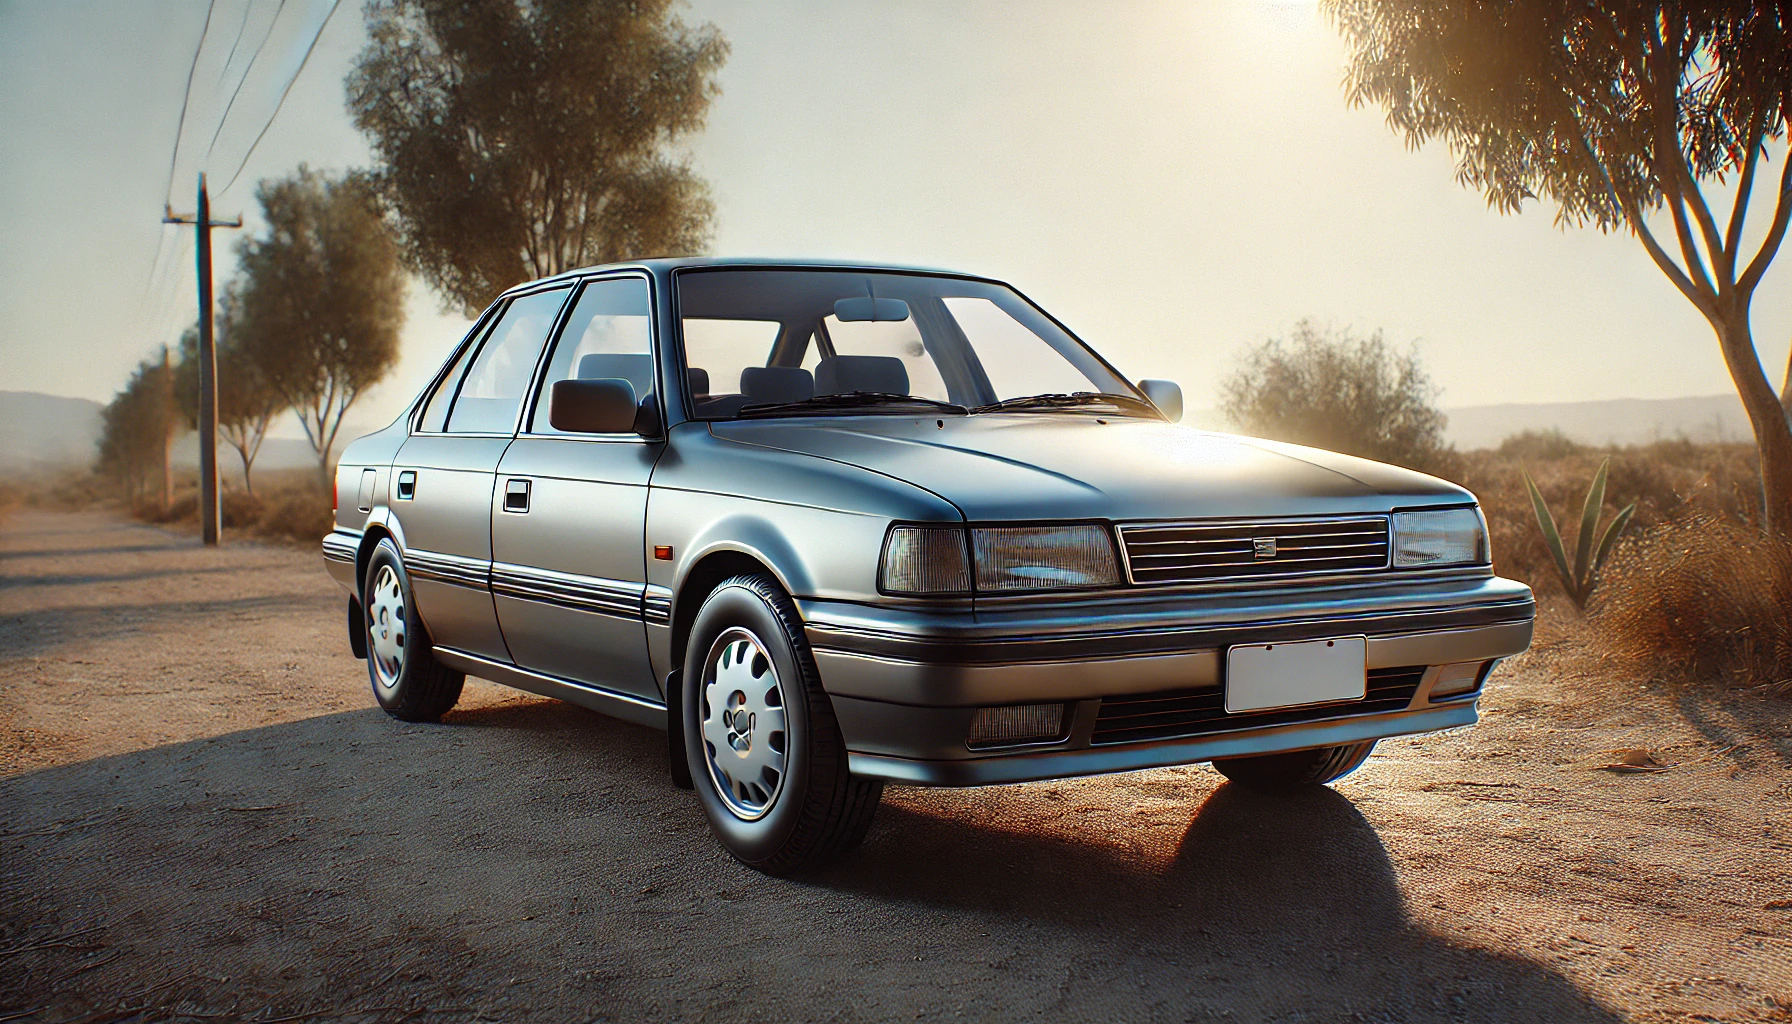

In [45]:
novo_automovel_1 <- data.frame(
  Estilo = 'seda',
  Ano = 1996,
  Potencia_motor = 120
)

In [46]:
# Fazendo a previsão do valor
predicao <- predict(modelo_boosting, new_data = novo_automovel_1)
predicao

.pred
<dbl>
2002.039


###**Automóvel 2**
> estilo minivan, ano 2003, potência do motor de 170

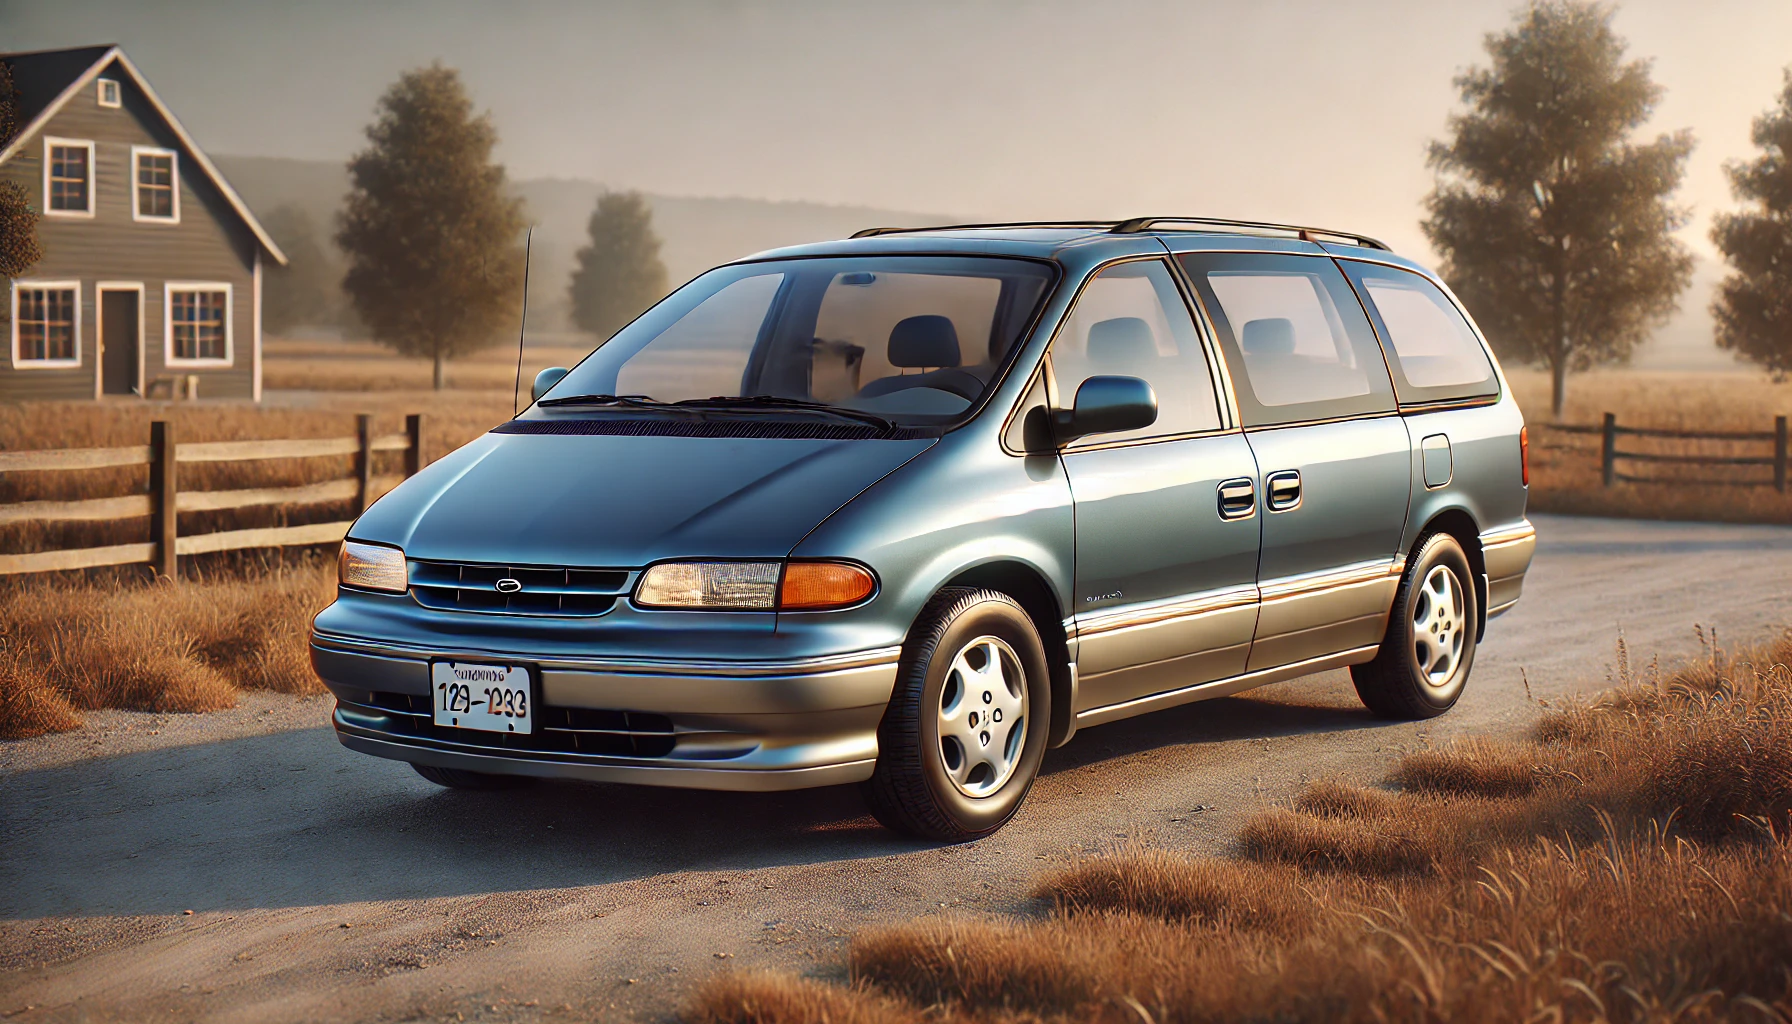

In [47]:
novo_automovel_2 <- data.frame(
  Estilo = 'minivan de passageiros',
  Ano = 2003,
  Potencia_motor = 170
)

In [48]:
# Fazendo a previsão do valor
predicao <- predict(modelo_boosting, new_data = novo_automovel_2)
predicao

.pred
<dbl>
23631.82


###**Automóvel 3**
> estilo SUV 4 portas, ano 2016, potência do motor de 220

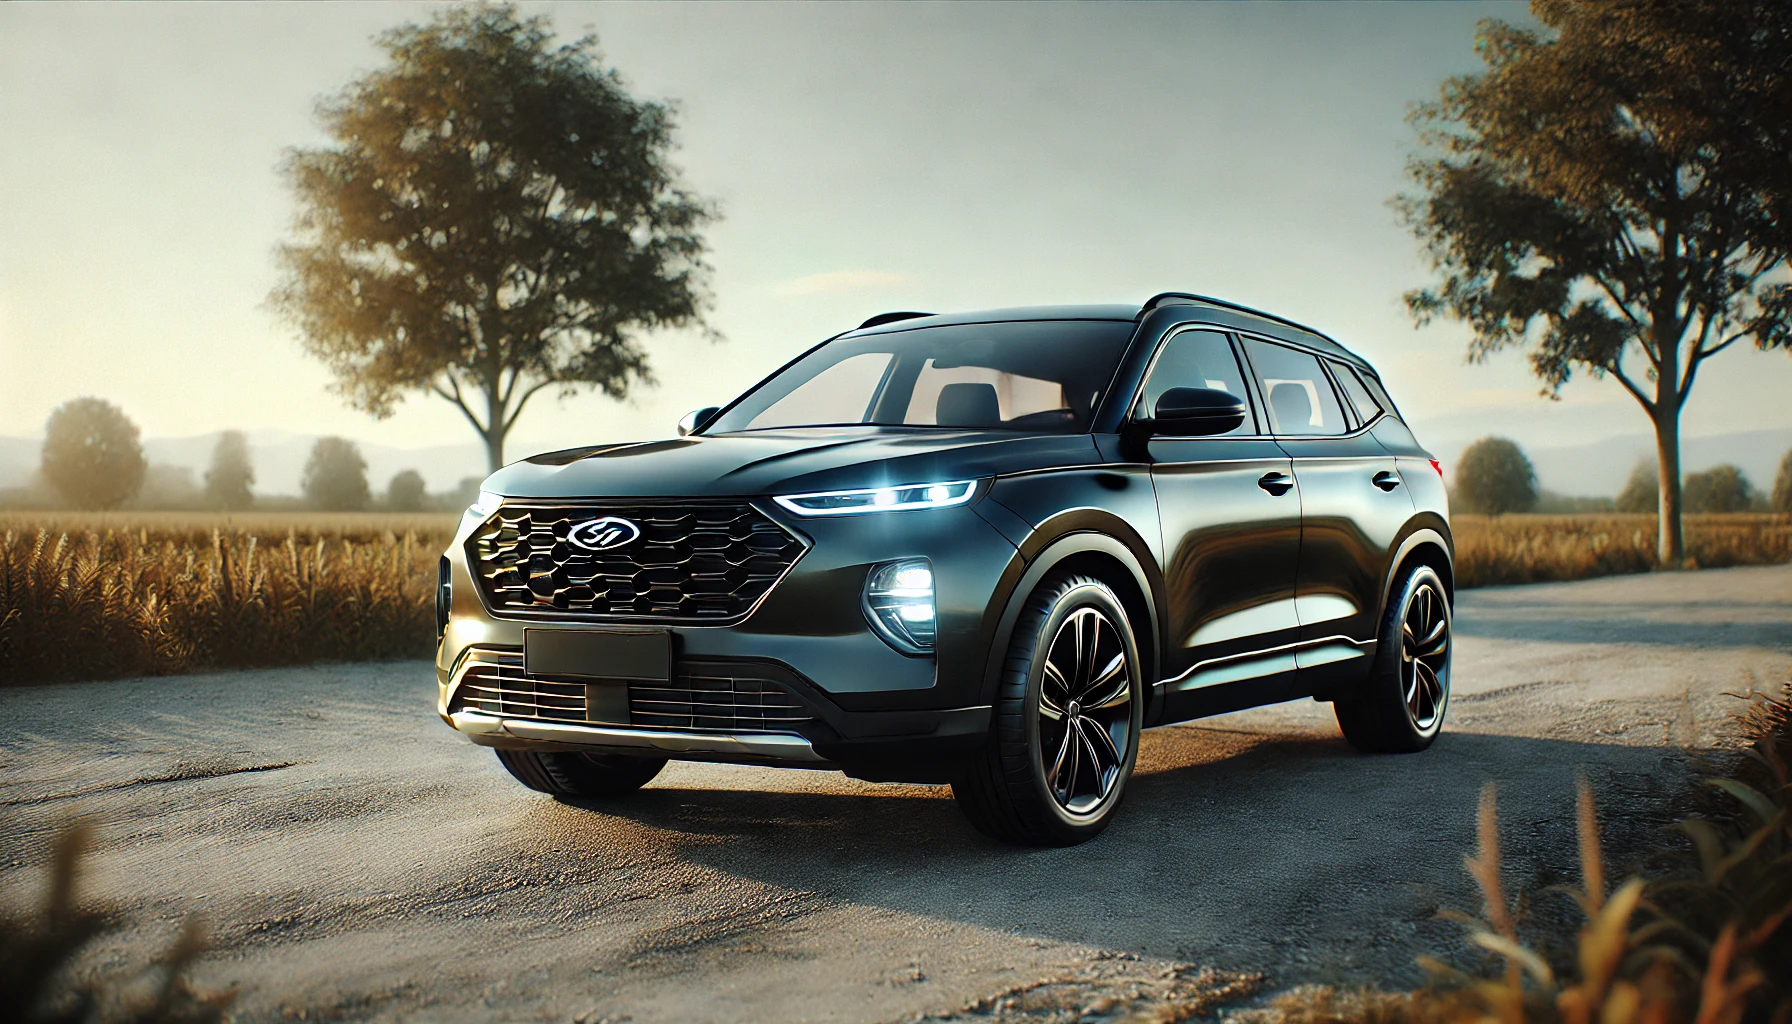

In [49]:
novo_automovel_3 <- data.frame(
  Estilo = 'SUV 4 portas',
  Ano = 2016,
  Potencia_motor = 220
)

In [50]:
# Fazendo a previsão do valor
predicao <- predict(modelo_boosting, new_data = novo_automovel_3)
predicao

.pred
<dbl>
41335.67
